# Trajectory generating

In [4]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise

# Kalman filter

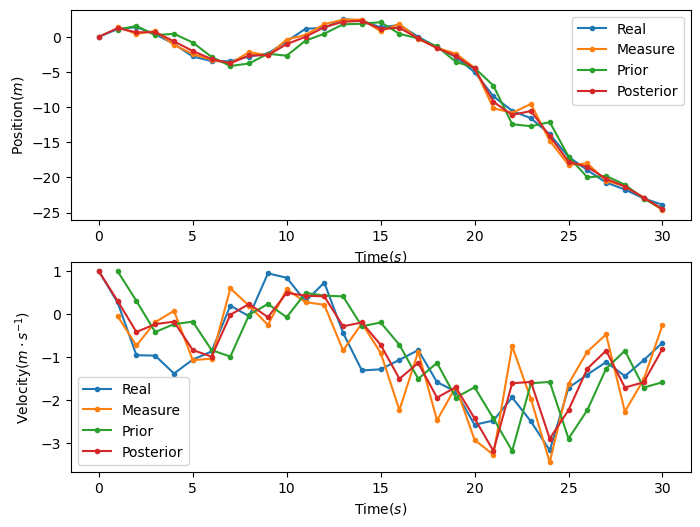

In [1]:
import numpy as np



x = np.matrix([[0.0],
               [1.0]])    
x_hat = np.matrix([[0.0],
                   [1.0]])  

Q = np.matrix([[0.5, 0.0],
               [0.0, 0.5]])   
R = np.matrix([[0.5, 0.0],
               [0.0, 0.5]])  

A = np.matrix([[1, 1],
               [0, 1]])    
H = np.matrix([[1.0, 0.0],
               [0.0, 1.0]]) 
p = np.matrix([[1.0, 0.0],
               [0.0, 1.0]]) 


x_log = x
z_log = np.matrix([[], []])
x_hat_log = x_hat
x_phat_log = np.matrix([[], []])  

N_step = 30
for i in range(0, N_step):
    
    # True model
    P_noise = rd.randn(Q.shape[0], 1)*np.diag(Q).reshape(-1, 1)**0.5
    x = A*x + P_noise
    x_log = np.hstack((x_log, x))

    M_noise = rd.randn(R.shape[0], 1)*np.diag(R).reshape(-1, 1)**0.5
    z = H*x + M_noise
    z_log = np.hstack((z_log, z))

    # KF
    #predict
    x_phat = A*x_hat   
    p_p = A*p*A.T + Q  
    x_phat_log = np.hstack((x_phat_log, x_phat))

    # update
    k = p_p*H.T*(H*p_p*H.T + R)**-1
    x_hat = x_phat + k*(z - H*x_phat)
    p = (np.mat(np.identity(2)) - k*H)*p_p
    x_hat_log = np.hstack((x_hat_log, x_hat))

legend_text = ['Real', 'Measure', 'Prior', 'Posterior']
plt.figure(figsize=(8, 6))

plt.subplot(211)
plt.plot(range(0, N_step+1), x_log[0, :].T,
         range(1, N_step+1), z_log[0, :].T,
         range(1, N_step+1), x_phat_log[0, :].T,
         range(0, N_step+1), x_hat_log[0, :].T, marker='.')
plt.legend(legend_text)
plt.xlabel('Time($s$)')
plt.ylabel('Position($m$)')

plt.subplot(212)
plt.plot(range(0, N_step+1), x_log[1, :].T,
         range(1, N_step+1), z_log[1, :].T,
         range(1, N_step+1), x_phat_log[1, :].T,
         range(0, N_step+1), x_hat_log[1, :].T, marker='.')
plt.legend(legend_text)
plt.xlabel('Time($s$)')
plt.ylabel('Velocity($m\cdot s^{-1}$)')

plt.savefig('KF.svg')

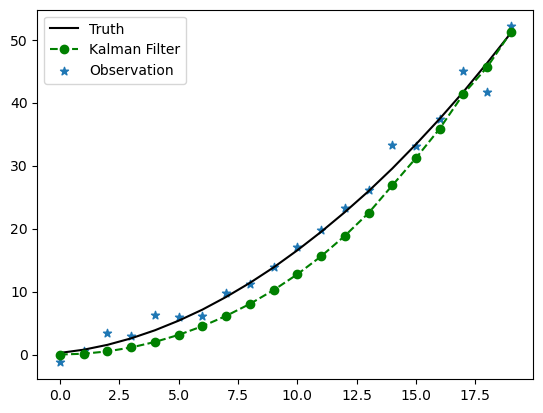

In [2]:

import numpy as np
import matplotlib.pyplot as plt

"""
X(k) = AX(k-1) + BU(k-1) + w(k-1)
Z(k) = HX(k) + e(k)
p(w) = N(0, Q)
p(e) = N(0, R)
"""

def P_update(X, P, A, Q, B, U):
    X_p = A@X + B*U
    P_p = (A@P)@A.T + Q
    return (X_p, P_p)


        
def M_update(X_p, P_p, Z, H, R):
    V = Z - H@X_p
    K = (P_p@H.T)@np.linalg.pinv((H@P_p)@H.T + R) #Kalman gain
    X_m = X_p + K@V
    P_m = (np.eye(K.shape[0]) - K@H) @ P_p
    return (X_m, P_m, K)

"""
process model 
x' = v
v' = a
a' = 0 

x(k) = x(k-1)+t*v(k)+0.5*t^2*a(k)
v(k) = v(k-1)+t*a(k)
a(k) = a(k-1)

measurement model
z(k) = x(k) + e

"""

n = 20 #Length
nx = 3 
t = np.linspace(0,3,n) 
dt = t[1] - t[0]

#True value settings
a_true = np.ones(n)*9.8 + np.random.normal(0,1,size=n)
v_true = np.cumsum(a_true*dt)
x_true = np.cumsum(v_true*dt)
X_true = np.concatenate([x_true, v_true, a_true]).reshape([nx,-1])


# Measurement noise covariance
R = np.diag([10**2])

#Observeation
e = np.random.normal(0,2,n)
x_obs = x_true + e

#localization model
A = np.array([[1,dt,0.5*dt**2],[0,1,dt],[0,0,1]])
B = 0
U = 0
H = np.array([1,0,0]).reshape([1,nx])

#State initialization
x0 = 0
v0 = 0
a0 = 10.0
X0 = np.stack([x0,v0,a0]).reshape(nx,1)

#Covariance initialization
P0 = np.diag([0**2,0**2,0.2**2])

#Process noise covariance initialization
Q = np.diag([0.0**2,0**2,1**2])


Xp_list = np.copy(X0)
Pp_list = [P0]
Xm_list = np.copy(X0)
Pm_list = [P0]

for i in range(1,n):
    Xi = Xm_list[:,-1].reshape([nx,1])
    Pi = Pm_list[-1]
    Xp, Pp = P_update(Xi, Pi, A, Q, B, U)
    Xp_list = np.concatenate([Xp_list, Xp], axis=1)
    Pp_list.append(Pp)

    Zi = np.array(x_obs[i]).reshape([1,1])
    Xm, Pm, K = M_update(Xp, Pp, Zi, H, R)
    Xm_list = np.concatenate([Xm_list, Xm], axis=1)
    Pm_list.append(Pm)

#Ploting
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_true, 'k-', label="Truth")
ax1.plot(Xm_list[0,:], 'go--', label="Kalman Filter")
ax1.scatter(np.arange(n), x_obs, label="Observation", marker='*')

plt.legend()
plt.show()


# Constant velocity+ phase model : EKF

In [9]:
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise
import math
import numpy as np
import matplotlib.pyplot as plt
lmb = 2e-3
q0=np.array([0.1,0])

def HJacobian_at(x):
    """ compute Jacobian of H at x """
    target=np.array([x[0],x[1]])
    distancetoantenna = np.linalg.norm(target-q0)
    J1=(((target[0]-q0[0])*4*math.pi/lmb)/distancetoantenna)%(2*math.pi)
    J2=((target[1]-q0[1])*4*math.pi/lmb)/distancetoantenna%(2*math.pi)
    return  np.array([[J1[0],J2[0],0,0]])
def Hx(x):
    """ compute measurement that
    would correspond to state x.""" 
    target=np.array([x[0],x[1]])
    distancetoantenna = np.linalg.norm(target-q0)
    phi_0=0
    phase = (distancetoantenna * 4*math.pi/lmb+phi_0) % (2*math.pi)
    return phase

def Contant_velocity_EKF(itr):
    dt = 0.1
    F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
    # Process Noise Covariance
    sv = 0.1
    G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
    Q = G*G.T*sv**2
    R = 1.*np.eye(1)
    real_state = []
    x = np.array([0,0,4,5]).reshape(4,1)
    measurements = []

    #True SS model
    #process(motion) model 
    #observation model
    for i in range(itr):
        real_state.append(x)
        x = np.dot(F,x)+np.random.multivariate_normal(mean=(0,0,0,0),cov=Q).reshape(4,1)
        target=np.array([x[0],x[1]])
        distancetoantenna = np.linalg.norm(target-q0)
        phi_0 = 0
        phase = (distancetoantenna * 4*math.pi/lmb) % (2*math.pi)
        measurements.append(np.array(phase+np.random.normal(0,R)).reshape(1,1))

    #KF
    
    # Initialization
    P = 5*np.eye(4)
    x0=np.random.multivariate_normal(mean=(0,0,0,0),cov=P).reshape(4,1)
    
    #filter
    kf =ExtendedKalmanFilter(dim_x=4, dim_z=1) 
    #
    kf.x = x0 
    kf.F = F 
    kf.P = P 
    kf.R = R 
    kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=2e-2)

    filter_result=list()
    filter_result.append(x)
    for i in range(1,itr):
        z = measurements[i]
        kf.predict()
        kf.update(z,HJacobian_at,Hx)
        filter_result.append(kf.x)
    filter_result=np.squeeze(np.array(filter_result))
    
    measurements = np.array(measurements)
    real_state = np.array(real_state)
    filter_result = np.array(filter_result)
    return measurements,real_state,filter_result

def plot_result(measurements,real_state,filter_result):
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(measurements)), measurements[1:,0], label = 'Measurements')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('phase [rad]',fontsize=14)

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,0], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,0], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,1], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,1], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,2], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,2], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m]',fontsize=14)
    plt.show()

    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,3], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,3], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m]',fontsize=14)
    plt.show()




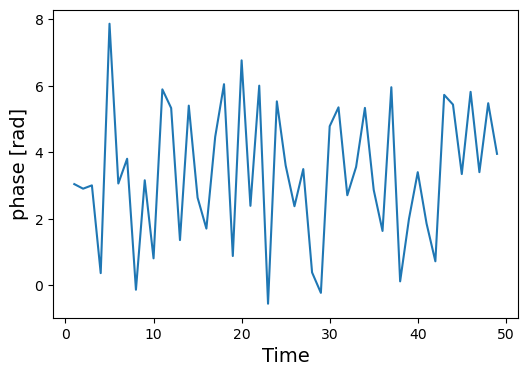

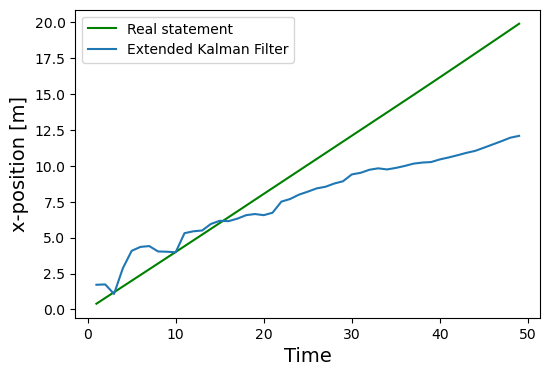

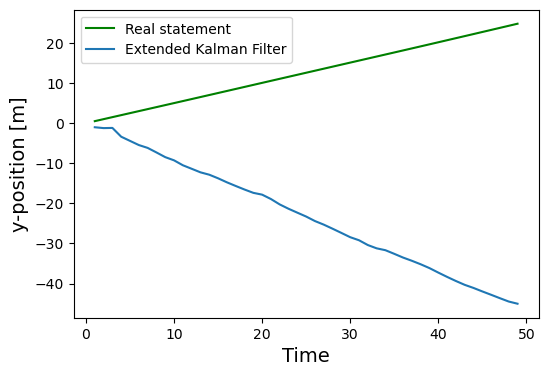

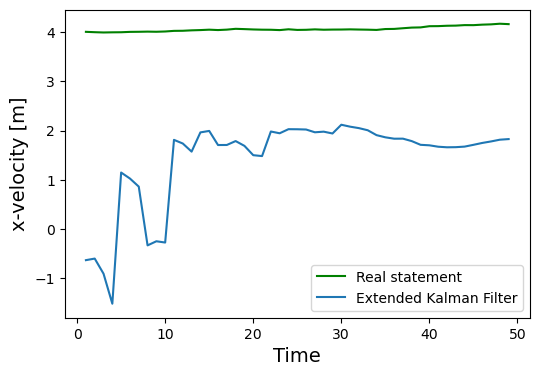

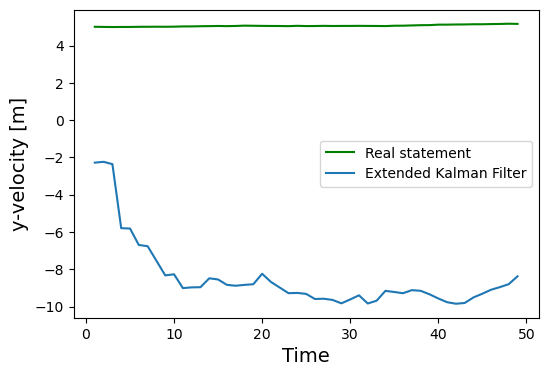

In [11]:
# measurements,real_state,filter_result=demo()
# plot_result(measurements,real_state,filter_result)
measurements,real_state,filter_result = Contant_velocity_EKF(itr=50)
plot_result(measurements,real_state,filter_result)

# Constant velocity+ phase model : EKF prior + ML

In [12]:
def array(num_elements,dim,x_start):
    lin_array=np.zeros((num_elements,2))
    lin_array[:,0]=[i for i in np.linspace(x_start,x_start+dim,num_elements)]#y_axis
    lin_array[:,1]=[ 0 for _ in range(num_elements)]#x_axis
    return lin_array

In [5]:
def near_field_Boundary(lamb,arr_dim):
    return 2*arr_dim**2/lamb

def sample_in_half_circle(R,N):
    samples=np.zeros((N,2))
    count=0
    while(count<N):       
        x=(np.random.uniform(0,1,1)-0.5)*2*R#U[-R,R]
        y=np.random.uniform(0,1,1)*R# U[0,R]
        if(x**2+y**2<=R**2):
            samples[count]=np.array([x,y]).reshape(2,)
            count+=1
    return samples

In [6]:
class ML:
    def ML_grid(self,xrange,yrange,phase_obs,arr,lamb,resolution,flag_plot=True):
        
        N=arr.shape[0]
        num_grid_x=int(np.floor((xrange[1]-xrange[0])/resolution))+1
        num_grid_y=int(np.floor((yrange[1]-yrange[0])/resolution))+1
        print(num_grid_x)
        print(num_grid_y)

        grid_x, step_x=np.linspace(xrange[0],xrange[1],num_grid_x,retstep=True)
        grid_y, step_y=np.linspace(yrange[0],yrange[1],num_grid_y,retstep=True)
        
        objective_values=np.zeros((num_grid_x,num_grid_y))
        for i in range(num_grid_x):
            for j in range(num_grid_y):
                p=np.array([grid_x[i],grid_y[j]])
                distance=np.array([np.linalg.norm(arr[k]-p) for k in range(N)])
                phase_obs_diff=phase_obs-phase_obs[0]
                phase_model_diff=4*np.pi/lamb*(distance-distance[0])
                objective_values[i,j]=np.cos(phase_obs_diff-phase_model_diff).sum()

        a,b=np.where(objective_values==np.max(objective_values))
        loc=np.array([grid_x[a[0]],grid_y[b[0]]])
        
        
#         print(f"ML estimation is{loc}")


        if(flag_plot):
            fig,ax=plt.subplots(figsize=(8,6))
            df = pd.DataFrame( objective_values.T,
                          columns=np.round(grid_x,3),
                          index=np.round(grid_y,3)
                          )
            #plotting
            sns.set_context({"figure.figsize":(5,5)})
            sns.heatmap(data=df,square=True,cmap="gist_gray")

            #ax.axes.yaxis.set_ticks([])
            #ax.axes.xaxis.set_ticks([])
            plt.xlabel('x')
            plt.ylabel('y')

            plt.scatter(a,b,c="red")
            plt.title(f'Grid searching result with resolution= {resolution/lamb}wavelength')
        
        loc=loc.reshape([-1,2])

        return np.array([num_grid_x,num_grid_y]),loc
    
    def ML_grid2(self,xrange,yrange,phase_obs,arr,lamb,resolution,num_ite,flag_plot=True):
        #hierarchical grid searching
        reso=resolution
        search_left_bound=xrange[0]
        search_right_bound=xrange[1]
        search_lower_bound=yrange[0]
        search_upper_bound=yrange[1]
        locs=[]
        
        for k in range(num_ite):
            
            num_grid_x=int(np.floor((search_right_bound-search_left_bound)/reso))
            num_grid_y=int(np.floor((search_upper_bound-search_lower_bound)/reso))

#             print(num_grid_x,num_grid_y)
            
            
            grid_x=np.arange(search_left_bound+0.5*reso,search_left_bound+(num_grid_x)*reso,reso)
            grid_y=np.arange(search_lower_bound+0.5*reso,search_lower_bound+(num_grid_y)*reso,reso)
#             print(len(grid_x),len(grid_y))
            objective_values=np.zeros((num_grid_x,num_grid_y))
            for i in range(num_grid_x):
                for j in range(num_grid_y):
                    p=np.array([grid_x[i],grid_y[j]])
                    distance=np.array([np.linalg.norm(arr[k]-p) for k in range(N)])
                    phase_obs_diff=phase_obs-phase_obs[0]
                    phase_model_diff=4*np.pi/lamb*(distance-distance[0])
                    objective_values[i,j]=np.cos(phase_obs_diff-phase_model_diff).sum()

            a,b=np.where(objective_values==np.max(objective_values))
            loc=np.array([grid_x[a[0]],grid_y[b[0]]])
            locs=np.append(locs, loc)


            if(flag_plot):
                plt.figure()
                fig,ax=plt.subplots(figsize=(8,6))
                df = pd.DataFrame( objective_values.T,
                              columns=np.round(grid_x,3),
                              index=np.round(grid_y,3)
                              )
                #plotting
                sns.set_context({"figure.figsize":(5,5)})
                sns.heatmap(data=df,square=True,annot=False,cmap="gist_gray")

                plt.xlabel('x')
                plt.ylabel('y')

                plt.text(a+0.5,b+0.5,'target',c="red",ha='center',va='center')
                ax.add_patch(plt.Rectangle((a-2,b-2), 5,5, color="blue", fill=False, linewidth=1))
                plt.title(f'Searching result with resolution= {reso/lamb}wavelength,ite={k+1}')

#                 plt.savefig(f'C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_4/ML2_Result_{k+1}.png')
            
            #increase the resolution and search within the best grid
            
            search_left_bound=max(loc[0]-reso*2.5,search_left_bound)
            search_right_bound=min(loc[0]+reso*2.5,search_right_bound)
            search_lower_bound=max(loc[1]-reso*2.5,search_lower_bound)
            search_upper_bound=min(loc[1]+reso*2.5,search_upper_bound)
            reso=0.25*reso
#             print(reso,search_left_bound,search_right_bound,search_lower_bound,search_upper_bound)
            
        locs=locs.reshape([-1,2])
        return np.max(objective_values),locs
    
    def plotting(self,size,f,targets,Loc_MLgrid,xrange,yrange):
        plt.figure(figsize=(4,4))
        plt.scatter(arr[:,0],arr[:,1],color='black')
        for i in range(len(targets)):
            plt.scatter(targets[i,0],targets[i,1],color='green',s=size)
        for j in range(Loc_MLgrid.shape[0]):
            plt.scatter(Loc_MLgrid[j,0],Loc_MLgrid[j,1],color='red',s=size)
            plt.text(Loc_MLgrid[j,0],Loc_MLgrid[j,1],j+1)
        plt.scatter(Loc_MLgrid[0],Loc_MLgrid[1],color='red',s=size)
        plt.title('ML result',fontsize=f)
        plt.legend(['array','true','loc_grid'],loc='upper left',fontsize=f)
        plt.xlim([xrange[0],xrange[1]])
        plt.ylim([yrange[0],yrange[1]])
        plt.xlabel('x axis [m]',fontsize=f)
        plt.ylabel('y axis [m]',fontsize=f)
        

In [7]:

def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """
    
    return  np.array([[1.,0,0,0],[0,1,0,0]])
def Hx(x):
    return np.array([x[0],x[1]])
def Contant_velocity_EKF(itr):
        
    dt = 0.1
    F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
    # Process Noise Covariance
    sv = 0.1
    G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
    Q = G*G.T*sv**2
    R = 3.*np.eye(2)
    real_state = []
    x = np.array([0,0,4,5]).reshape(4,1)
    measurements = []
    #process(motion) model 
    #observation model
    for i in range(itr):
        real_state.append(x)
        x = np.dot(F,x)+np.random.multivariate_normal(mean=(0,0,0,0),cov=Q).reshape(4,1)
        measurements.append(np.array(x[0:2,:]+np.random.multivariate_normal(mean=(0,0),cov=R).reshape(2,1)))


    
    # initialization
    P = 5*np.eye(4)
    x0=np.random.multivariate_normal(mean=(0,0,0,0),cov=P).reshape(4,1)
    
    #filter
    kf =ExtendedKalmanFilter(dim_x=4, dim_z=2)  #dim_x:隐状态大小，dim_z:量测大小
    #定义参数 
    kf.x = x0 #初始状态[位置,速度]
    kf.F = F #状态转移矩阵
    kf.H = np.array([[1.,0,0,0],[0,1,0,0]])  #量测矩阵
    kf.P = P #初始状态协方差
    kf.R = R #量测噪声
    kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=2e-2) #过程（系统）噪声

    filter_result=list()
    filter_result.append(x)
    for i in range(1,itr):
        z = measurements[i]
        kf.predict()
        kf.update(z,HJacobian_at,Hx)
        filter_result.append(kf.x)
    filter_result=np.squeeze(np.array(filter_result))
    
    measurements = np.array(measurements)
    real_state = np.array(real_state)
    filter_result = np.array(filter_result)
    return measurements,real_state,filter_result
def plot_result(measurements,real_state,filter_result):
    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(measurements)), measurements[1:,0], label = 'Measurements')
    plt.plot(range(1,len(real_state)), real_state[1:,0], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,0], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(measurements)), measurements[1:,1], label = 'Measurements')
    plt.plot(range(1,len(real_state)), real_state[1:,1], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,1], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,2], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,2], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m]',fontsize=14)
    plt.show()

    
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(real_state)), real_state[1:,3], label = 'Real statement',c='g' )
    plt.plot(range(1,len(filter_result)), np.array(filter_result)[1:,3], label = 'Extended Kalman Filter')
    plt.legend()
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m]',fontsize=14)
    plt.show()



In [8]:
# measurements,real_state,filter_result=demo()
# plot_result(measurements,real_state,filter_result)
measurements,real_state,filter_result = Contant_velocity_EKF(itr=50)
plot_result(measurements,real_state,filter_result)

NameError: name 'Q_discrete_white_noise' is not defined